In [2]:
import pandas as pd
from collections import Counter
import warnings, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import keras
from keras.layers import Embedding, Flatten, Dense, GlobalMaxPool1D, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import nltk
from nltk.corpus import stopwords
import string
import gensim
from gensim import corpora
from gensim import matutils, models
import scipy.sparse
import pyLDAvis
import pyLDAvis.gensim  

# 1. Data Preparation

The texts for this analysis are prepared by joining two datasets which contains certain information about products. I will be concatenating two columns - titles and categories - for each product to form the corpus. 
The analysis will use this corpus to perform a classification task to assign the product categories (benchark_category_2).

In [30]:
# get the first file which has product titles and categories
df1 = pd.read_csv('\\Users\\Dan\\Documents\\Python\\Data\\Flix_products\\product_title.csv', engine='python')
df1.head(2)

,product_id,title,Categories
0,400002,HP Photosmart eStation Printer,Printers and Multifunction | Inkjet All-in-One...
1,400004,HP LaserJet Pro M1217nfw Multifunction Printer,Printers and Multifunction | Laser Multifuncti...


In [31]:
# get second product file with only the necessary columns. benchark_category_2 is the product categories to be predicted
products_complete = pd.read_csv('\\Users\\Dan\\Documents\\Python\\Data\\Flix_products\\products.csv', sep='\t')
products= products_complete[['product_id','product_title', 'brand_title', 'benchmark_category2']]
products.head(2)

C:\Users\Dan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,product_id,product_title,brand_title,benchmark_category2
0,3,Crematic Coffee Maker,Groupe SEB,Drink Makers
1,4,Vitamin Plus 3-Tier Steamer,Tefal,Steamers


In [32]:
# merge the two products file with an inner join to keep only the common products
products = pd.merge(products, df1, on='product_id', how='inner')
products.head()

,product_id,product_title,brand_title,benchmark_category2,title,Categories
0,881868,HP EliteBook 840 G1 Notebook PC,HP,Laptops,HP EliteBook 840 G1 Notebook PC,Laptops And Hybrids | Business Laptop PCs | HP...
1,876236,Speedlight SB-N7,Nikon,Cameras Accessories,Speedlight SB-N7,Speedlights
2,888696,Electrolux EFC60465OX 60 cm Stainless Steel Ch...,Electrolux Major,Cookers/Ovens,Electrolux EFC60465OX Chimney Design Hood 60 c...,Electrolux | NonStar | Cooker_Hood
3,888693,Electrolux EFC90468OX 90 cm Stainless Steel Ch...,Electrolux Major,Cookers/Ovens,Electrolux EFC90468OX Chimney Design Hood 90 c...,Electrolux | NonStar | Cooker_Hood
4,888664,Oven EVY9841AOX,Electrolux Major,Cookers/Ovens,Electrolux EVY9841AOX Steam Cooking Built-in C...,Electrolux | NonStar | Oven


# 2. Exploratory Data Analysis

Now that the dataset is ready, I need to perform some exploration of the dataset to understand it better.

In [35]:
# let's look at the summary of the dataframe
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70774 entries, 0 to 70773
Data columns (total 6 columns):
product_id             70774 non-null int64
product_title          69909 non-null object
brand_title            70773 non-null object
benchmark_category2    67109 non-null object
title                  70774 non-null object
Categories             70774 non-null object
dtypes: int64(1), object(5)
memory usage: 3.8+ MB


In [36]:
# check how many products have unassigned categories
print(products['benchmark_category2'].isna().sum()),
print('percentage of products with no categories: {}'.format(products['benchmark_category2'].isna().sum()/len(products.index)))

3665
percentage of products with no categories: 0.05178455364964535


In [37]:
# lets drop the unassugned category products as they are of no use
products.dropna(subset=['benchmark_category2'], inplace=True)

Text(0.5, 0, 'number of products')

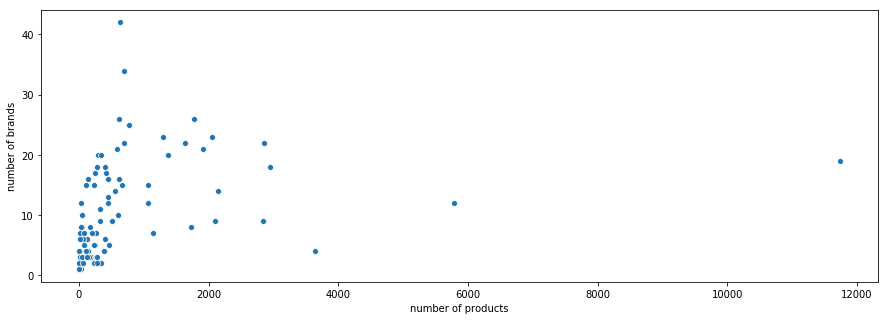

In [38]:
# let's look at the number of products and brand distribution for the categories
group_products = products.groupby('benchmark_category2')['product_id'].count()
group_brand  = products.groupby('benchmark_category2')['brand_title'].nunique()
plt.figure(figsize=(15,5))
ax = sns.scatterplot(x=group_products, y=group_brand)
ax.set_ylabel('number of brands')
ax.set_xlabel('number of products')

Seems like there are few categories which has a lot of products, however, they seem to be concentrated below 2000 products

In [39]:
# lets look at the number of unique categories in the dataset
len(set(products['benchmark_category2']))

103

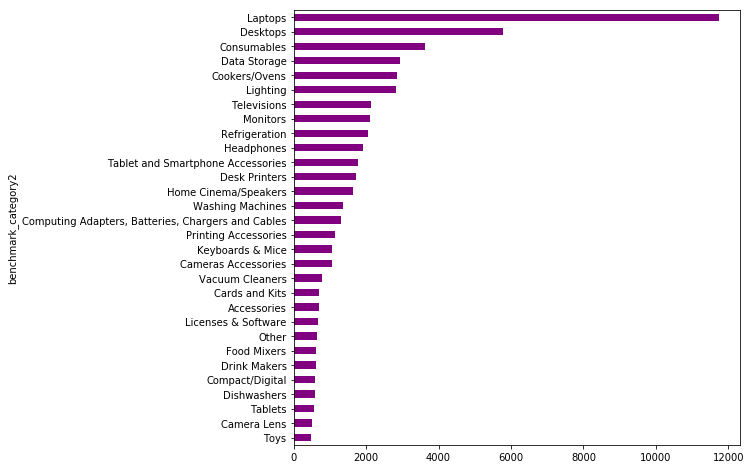

In [40]:
# lets look at the top 30 categories by number of products
products.groupby('benchmark_category2')['product_id'].count().sort_values().tail(30).plot.barh(figsize=(8,8), color='purple')

It seems the products distribution is quite ueneven across the categories and it seem to have a long tail as we approach the lower end of the distribution. For the sake of the analysis I'll consider only the top 50 categories by product count as running a classification task on too many classes is not ideal.

In [41]:
# lets subset by top 50 categories and use this data for further analysis
top_Ncats = products.groupby('benchmark_category2')['product_id'].count().nlargest(50).keys()
prod_Ncats = products[products['benchmark_category2'].isin(top_Ncats)].reset_index(drop=True)
prod_Ncats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63349 entries, 0 to 63348
Data columns (total 6 columns):
product_id             63349 non-null int64
product_title          62578 non-null object
brand_title            63349 non-null object
benchmark_category2    63349 non-null object
title                  63349 non-null object
Categories             63349 non-null object
dtypes: int64(1), object(5)
memory usage: 2.9+ MB


In [42]:
# portion of overall data in the top 50 categories
len(prod_Ncats)/len(products)*100

94.39717474556318

As we see the top 50 categories has 94% of the total products which is good enough for this analysis.

Lastly, we'll do one last step of data preparation : concatenate title and categories

In [45]:
# the Categories column has a pipe symbol which is used as a delimeter for taxonomy in the company database
prod_Ncats['Categories'].head(2)

0    Laptops And Hybrids  Business Laptop PCs  HP E...
1                                          Speedlights
Name: Categories, dtype: object

In [44]:
# Remove the pipes '|' in the Categories
prod_Ncats['Categories'] = prod_Ncats['Categories'].str.replace('|', '')
prod_Ncats['Categories'].head(2)

0    Laptops And Hybrids  Business Laptop PCs  HP E...
1                                          Speedlights
Name: Categories, dtype: object

In [46]:
# lets concatenate the two columns - product titles and categories - to a new column 'title&cat'
prod_Ncats['title&cat']=np.nan
for i in range(len(prod_Ncats)):
    if pd.isna(prod_Ncats.loc[i, 'product_title']):
        prod_Ncats.loc[i, 'title&cat'] =  prod_Ncats.loc[i, 'title'] + ' ' + prod_Ncats.loc[i, 'Categories']
    else:
        prod_Ncats.loc[i,'title&cat'] =  prod_Ncats.loc[i, 'product_title'] + ' ' + prod_Ncats.loc[i, 'Categories']

In [177]:
prod_Ncats.iloc[:,[0,2,3,6]].head()

,product_id,brand_title,benchmark_category2,title&cat
0,881868,HP,Laptops,HP EliteBook 840 G1 Notebook PC Laptops And Hy...
1,876236,Nikon,Cameras Accessories,Speedlight SB-N7 Speedlights
2,888696,Electrolux Major,Cookers/Ovens,Electrolux EFC60465OX 60 cm Stainless Steel Ch...
3,888693,Electrolux Major,Cookers/Ovens,Electrolux EFC90468OX 90 cm Stainless Steel Ch...
4,888664,Electrolux Major,Cookers/Ovens,Oven EVY9841AOX Electrolux NonStar Oven


# 3. Bag of Words 

Next step is to develop a Bag of Words from the entire document. To do so I need to tokenize the texts and do a bit of cleaning. Once the tokenization is complete, the entire vocabulary is ready to be used for various modelling techniques based on Bag of Words

In [47]:
# functions to clean and tokenize the whole doc and form a vocabulary

# clean texts
def tokenize_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # change to lower case
    tokens = [w.lower() for w in tokens]
    # remove remaining tokens that are not alphanumeric
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words in English (not sure how effective this has been)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load text and add to vocab
def add_to_vocab(column, vocab):
    for i in range(len(column)):
        tokens = tokenize_doc(column[i])
        vocab.update(tokens)  

In [48]:
# first tokenization process: create a vocabulary from the texts of 'title&cat' column.
vocab = Counter()
add_to_vocab(prod_Ncats['title&cat'], vocab)

The vocabulary created above is a dictionary which has every word and count of times it appears in the entire corpus. 

In [55]:
# lets look at the length of the vocab and 20 most occuring words
print(vocab.most_common(20)) 
print('Vocabulary size: {}'.format(len(vocab)))

[('hp', 81516), ('pc', 34871), ('notebook', 24464), ('series', 20676), ('pavilion', 11978), ('home', 9793), ('desktop', 9730), ('pcs', 9598), ('workstation', 7968), ('compaq', 7286), ('mobile', 7160), ('philips', 7101), ('consumer', 6220), ('tv', 6122), ('ink', 5807), ('elitebook', 5680), ('led', 5631), ('probook', 5555), ('printer', 5503), ('cartridges', 4748)]
Vocabulary size: 11832


In [49]:
# let's look at the 'title&cat' column of the dataframe from which the vocabulary is built
prod_Ncats['title&cat'].head()

0    HP EliteBook 840 G1 Notebook PC Laptops And Hy...
1                         Speedlight SB-N7 Speedlights
2    Electrolux EFC60465OX 60 cm Stainless Steel Ch...
3    Electrolux EFC90468OX 90 cm Stainless Steel Ch...
4            Oven EVY9841AOX Electrolux  NonStar  Oven
Name: title&cat, dtype: object

We have go through another step of tokenization which will remove words which occur just once in the entire corpus. This should remove the vocabulary size without much affecting in the future modelling outcomes.

In [53]:
# remove tokens with just one occurence to reduce the vocab size
tokens = [k for k,c in vocab.items() if c > 1]
print('Vocabulary size: {}'.format( len(tokens)))

Vocabulary size: 7373


As we see above the word count has shrunk significantly from 11,832 to 7,373.
The second process of tokinization will be preformed on each row of data so I keep only the words which are in the new vocabulary named as 'tokens'.

In [56]:
# function to tokenize each row
def tokenize_row(column, vocab):
    tokenz = []
    for i in range(len(column)):
        words = tokenize_doc(column[i])
        words = [w for w in words if w in tokens]
        tokenz.append(words)
    return tokenz

In [57]:
# tokenize each row and add them as a new column in the dataframe
prod_Ncats['tokens'] = tokenize_row(prod_Ncats['title&cat'], vocab)
prod_Ncats['tokens'].head()

0    [hp, elitebook, notebook, pc, laptops, hybrids...
1                            [speedlight, speedlights]
2    [electrolux, cm, stainless, steel, chimney, de...
3    [electrolux, cm, stainless, steel, chimney, de...
4                    [oven, electrolux, nonstar, oven]
Name: tokens, dtype: object

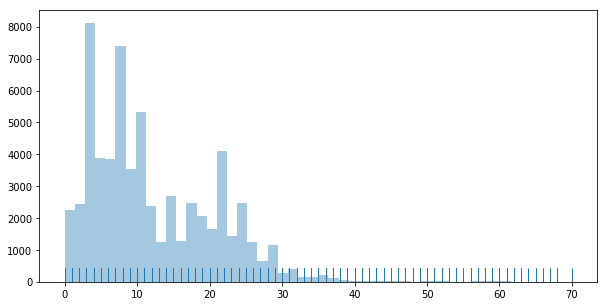

In [58]:
# histogram of token lengths per product
token_length = []
for i in range(len(prod_Ncats['tokens'])):
    token_length.append(len(prod_Ncats['tokens'][i]))
    
plt.figure(figsize=(10,5))   
sns.distplot(token_length, bins=50, kde=False, rug=True)

We can see from the histogram that majority of the token lengths of the products are quite short. It'll be interesting to find out if such short texts per product are good enough for a text classification task.

Finally, we need to convert the tokens of each product to a vectiorization friendly list.

In [59]:
# convert tokens in the list to texts to make it vectorizing freindly
prod_Ncats['tokens']=[" ".join(tokens) for tokens in prod_Ncats['tokens'].values]
prod_Ncats['tokens'].head()

0    hp elitebook notebook pc laptops hybrids busin...
1                               speedlight speedlights
2    electrolux cm stainless steel chimney design h...
3    electrolux cm stainless steel chimney design h...
4                         oven electrolux nonstar oven
Name: tokens, dtype: object

Before starting the modelling process, lets take a look a the distribution of products by the categories

We can see the classes in this dataset are highly uneven. This is an important step to take into account before starting to build any classification models.

# 4. Train and Test data split with stratified sampling

For any kind of classification process its a good strategy to first look at the class balance

In [60]:
# function to plot bar-chart of groupby agg counts
def bar_plot(df,group_column, agg):
    df.groupby(group_column)[agg].count().sort_values(ascending=False).plot.bar(figsize=(12,6), color='purple')

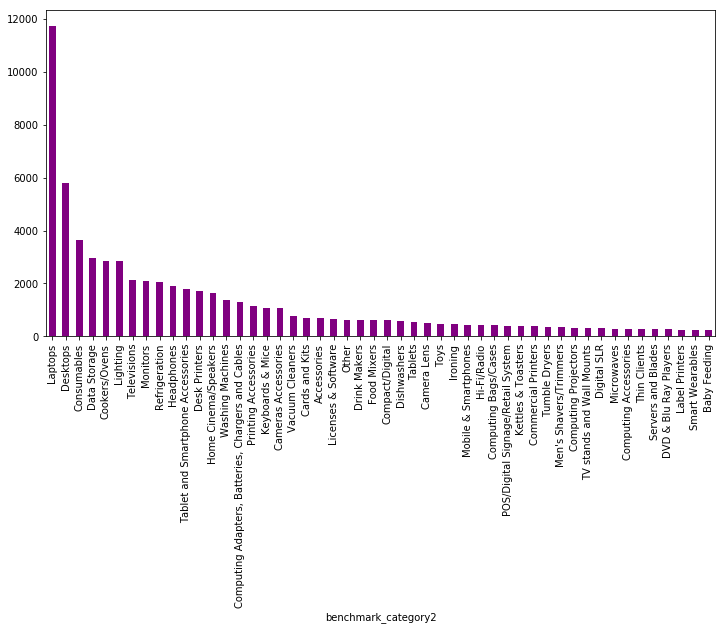

In [61]:
# plot the count of products by categories
bar_plot(prod_Ncats, 'benchmark_category2' ,'product_id')

As we see from above, we have huge imbalance in the classes. To have the a similar distribution among the classes in both test and train datasets we need to use stratified sampling while dividing the data.

In [62]:
# create train and test set with stratified sampling, keep 30% of the entire for testing
model_data = prod_Ncats.copy()
y = model_data.pop('benchmark_category2')
x = model_data['tokens']
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=42, stratify=y)

# 5. Feature Engineering

With the Bag of Words modelling, I use two set of features based on two of the most common feature engineering techniques used in NLP : TF-IDF and CountVectors.

TF-IDF Vectors as features:  

In [63]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [65]:
# generate the TF-IDF features and transform the train and test datasets
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{2,}', stop_words='english', max_features=7000)
tfidf_vect.fit(prod_Ncats['tokens'])
x_train_tfidf =  tfidf_vect.transform(x_train)
x_test_tfidf =  tfidf_vect.transform(x_test)

In [185]:
# lets look at one of the tran dataset transformation
x_train_tfidf[10,:200].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

One hot-encoding - CountVector as features

In [70]:
# generate the CountVector features and transform the tran and test datasets
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(prod_Ncats['tokens'])
x_train_CV =  count_vect.transform(x_train)
x_test_CV =  count_vect.transform(x_test)

# 6. Prediction Models on Bag of Words

In [75]:
# a class to train a classification model an extract key stats of each model
class train_model():
    def __init__(self,classifier, train_data, test_data):
        self.train = classifier.fit(train_data, y_train)
        self.predict = classifier.predict(test_data)
        self.cm = confusion_matrix(y_test, self.predict)
        self.precision = np.diag(self.cm) / np.sum(self.cm, axis = 0)
        self.recall = np.diag(self.cm) / np.sum(self.cm, axis = 1)  
        
    def return_metrics(self):
        print('Accuracy: {}'.format(metrics.accuracy_score(self.predict, y_test)))
        print('Average Precision: {}'.format(np.average(self.precision)))
        print('Average Recall: {}'.format(np.average(self.recall)))
    
    def return_predictions(self):
        return self.predict        

The prediction task is defined by a Class function which returns Accuracy and average Precision and Recall of the model.

I've also written a function to plot the wrong categories predicted for each of the model.

In [83]:
# function to plot the count of wrong predictions by categories
def plot_wrong_predictions(model):
    # extract the predictions
    predicted = model.return_predictions()
    # subset the training data rows from the main dataframe
    train_data = prod_Ncats.iloc[list(x_test.index.values),:]
    # add the predicted columns to the train_data
    train_data['predicted'] = encoder.inverse_transform(predicted)
    # extract the wrong predictions
    wrong_predictions = train_data[train_data['benchmark_category2'] != train_data['predicted']]
    # plot a count of the wrong categories
    #bar_plot(wrong_predictions, 'benchmark_category2' ,'product_id')  
    ax = wrong_predictions.groupby('benchmark_category2')['product_id'].nunique().sort_values(ascending=False).plot.bar(color='purple')
    ax.set_xlabel('categories')
    ax.set_ylabel('number of products')
    

TF-IDF Featureset Predictons

Here I'm using three classification models - Naive Bayes, Logistic Regression and Random Forests - to compare the results.

In [79]:
# train models on the TF-IDF features
# NB_tfidf = train_model(naive_bayes.MultinomialNB(), x_train_tfidf, x_test_tfidf)   # Naive Bayes
LR_tfidf = train_model(linear_model.LogisticRegression(), x_train_tfidf, x_test_tfidf)  # Logistic Regression
RF_tfidf = train_model(ensemble.RandomForestClassifier(), x_train_tfidf, x_test_tfidf)  # Random Forests

In [77]:
# measure the predictions
NB_tfidf.return_metrics()
LR_tfidf.return_metrics()
RF_tfidf.return_metrics()

Accuracy: 0.8852407261247041
Average Precision: nan
Average Recall: 0.7512788223593599
Accuracy: 0.931544330439358
Average Precision: 0.908306129890538
Average Recall: 0.8734228936342536
Accuracy: 0.9385951065509076
Average Precision: 0.9085553653931351
Average Recall: 0.8953669172610235


We can see that my classification models do a fantastic job with Logistic Regression and the Random Forest models achieving more than 93% accuracy and very good numbers of average Precision and Recall.

Lets now look at the wrong predictions and compare the worse performing model -Naive Bayes with one of the better performing model - Random Forest.

Text(0.5, 1.0, 'RF_tfidf wrong prdictions')

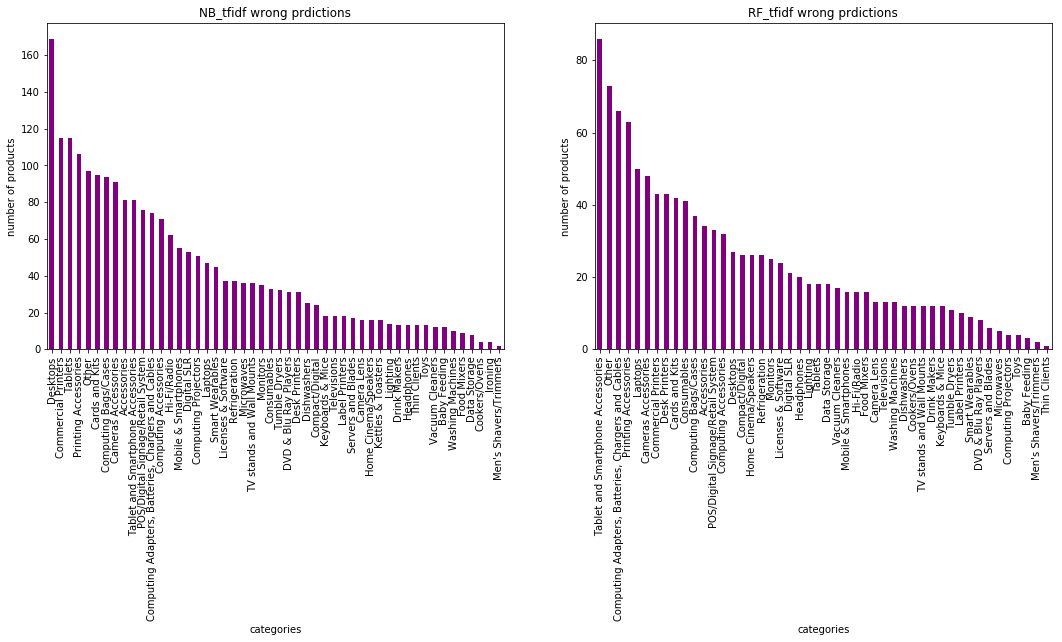

In [84]:
# compare the wrong predictions between two models
f, axs = plt.subplots(1,2,figsize=(18,6))
plt.subplot(1,2,1)
plot_wrong_predictions(NB_tfidf)
plt.title('NB_tfidf wrong prdictions')

plt.subplot(1,2,2)
plot_wrong_predictions(RF_tfidf)
plt.title('RF_tfidf wrong prdictions')

From a comparison of the two graphs above, it seems like the Naive Bayes model did a worse job at predicting Desktops, Commercial Printers and Tablets than the Random Forest model.

CountVector Featurest Predictions

In [85]:
# train models on the CountVector features
NB_CV = train_model(naive_bayes.MultinomialNB(), x_train_CV, x_test_CV)   # Naive Bayes
LR_CV = train_model(linear_model.LogisticRegression(), x_train_CV, x_test_CV)  # Logistic Regression
RF_CV = train_model(ensemble.RandomForestClassifier(), x_train_CV, x_test_CV)  # Random Forests

In [86]:
# measure the predictions
NB_CV.return_metrics()
LR_CV.return_metrics()
RF_CV.return_metrics()

Accuracy: 0.9147066561431202
Average Precision: 0.8911286514501086
Average Recall: 0.8423734475096124
Accuracy: 0.9396474611944226
Average Precision: 0.9153726168313553
Average Recall: 0.8924982471929165
Accuracy: 0.9359116022099447
Average Precision: 0.9038959311657717
Average Recall: 0.8890849760298155


Once we look at the prediction results, the Naive Bayes model has improved using the CountVector featureset and perform very close to the other two models. The overall performance of the best performing model - Logistic Regression with 93.96% accuracy - isn't a significant improvement from the 93.85% accuracy of the Random Forest model with TF-IDF featureset.

Now lets compare the wrong predictions of the Logistic Regression and Random Forest

Text(0.5, 1.0, 'RF_CV wrong prdictions')

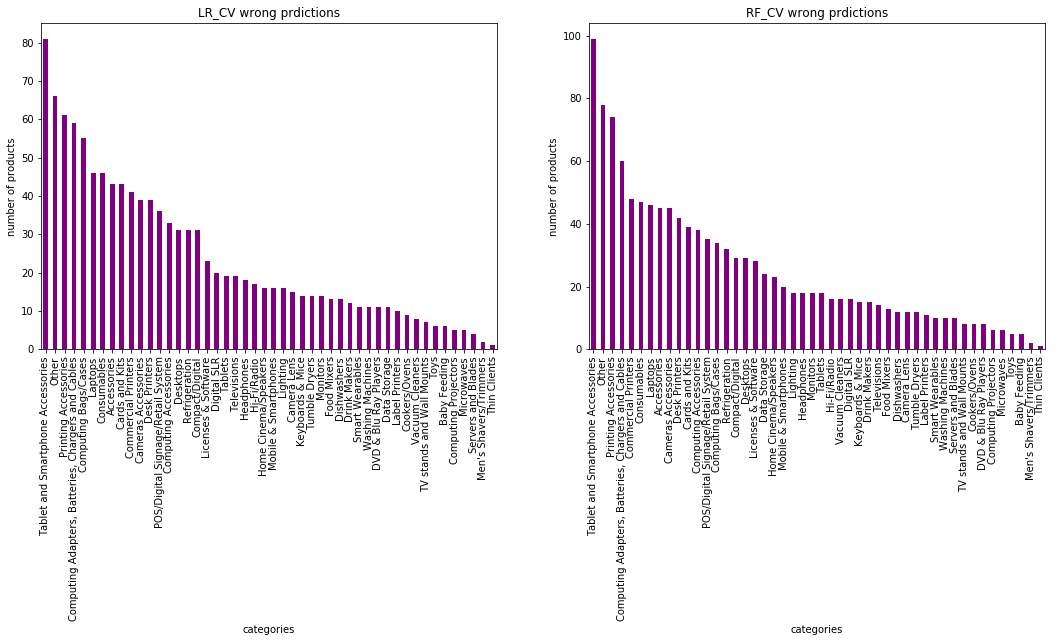

In [87]:
# compare the wrong predictions between two models
f, axs = plt.subplots(1,2,figsize=(18,6))
plt.subplot(1,2,1)
plot_wrong_predictions(LR_CV)
plt.title('LR_CV wrong prdictions')

plt.subplot(1,2,2)
plot_wrong_predictions(RF_CV)
plt.title('RF_CV wrong prdictions')

We can see that both the models did a very similar job at predicting the wrong categories.

Future improvements in the classification task can be achieved by applying more data cleaning techniques as well as improviving the original product categories itself. Performing further cleaning and re-categorisation of the dataset is beyond the scope of this project and I'll leave the predictions at its current state.

# 7. Word Embeddings

Word embeddings is another approach in NLP to perform various types of analysis. Here, I use this method for the classification of product categories.
Keras is the package used for training the Neural Netoworks which will perform the classification task.

The first step declare certain parameters which will be used in the modelling procedure.

In [18]:
# declare a cut-off length of words for each product document
maxlen = 30  
# trains on 70% of the samples
training_samples = round(0.7 * len(prod_50cats['tokens']))  
# considers only the top 7,000 words in the dataset
max_words = 7000    

Tokenization with Keras, keeping not more than 30 words per product document.
Then store the words as number index.

In [19]:
# converts each description to a list of integers considering only the max_words
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(prod_50cats['title&cat'])
# store the words as numbers
sequences = tokenizer.texts_to_sequences(prod_50cats['title&cat'])  

In [20]:
# each tokenized product document is cut to maxlen (30 words or padded 0 if less)
data = pad_sequences(sequences, maxlen=maxlen)   
data[0]

array([  0,   1,  20, 327, 113,   3,   2,  42,   6,  58,  26,  31,   9,
         1,  20, 156,   3,   9,   1,  20, 327,   3,   2,   4,   1,  20,
       327, 113,   3,   2])

In [21]:
# lets look at the word-index of number of words being stored
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
list(word_index.items())[:5]

Found 44614 unique tokens.


[('hp', 1), ('pc', 2), ('notebook', 3), ('series', 4), ('pavilion', 5)]

Once the tokenization and word indexing is done, we need to encode the categorical category classes to a numerical index.

In [22]:
# encode the target labels
encoder = preprocessing.LabelEncoder()
encoded_labels = encoder.fit_transform(prod_50cats['benchmark_category2'])
len(set(encoded_labels))

50

The classes or encoded labels futher needs to be transformed to a Keras format where each classes will be assigned 1 from a vector of length 50.

In [23]:
labels = keras.utils.to_categorical(encoded_labels)
labels.shape

(63349, 50)

In [24]:
# for example, the label[1] is represented in a vector of 50 units with just one of them assigned the value 1
labels[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [25]:
# now lets look at the shape of the tokenized texts and the label classes
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (63349, 30)
Shape of label tensor: (63349, 50)


In [26]:
# lets shuffle the data
indices = np.arange(data.shape[0])  
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [27]:
# divide train and test datasets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: ]
y_test = labels[training_samples: ]

Once we have the data encoding is complete, it's time to build the Neural Network model.

We start by first defining the model architechture. Here we are using a 3 layer model - input layer, hidden layer and an output layer. In this model we are also training the word embeddings from our own corpus rather than using pre-trained embeddings. 

In [28]:
# Training the same model without pretrained word embeddings
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 30
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(50, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 30)            210000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                57664     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
Total params: 270,914
Trainable params: 270,914
Non-trainable params: 0
_________________________________________________________________


Here I train the Neural Network on the training data and predict on the test data.

In [29]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, y_test))
model.save_weights('from scratch_model1')

Instructions for updating:
Use tf.cast instead.
Train on 44344 samples, validate on 19005 samples
Epoch 1/10
44344/44344 [==============================] - 10s 225us/step - loss: 1.1154 - acc: 0.7415 - val_loss: 0.4161 - val_acc: 0.8998
Epoch 2/10
44344/44344 [==============================] - 9s 206us/step - loss: 0.3432 - acc: 0.9179 - val_loss: 0.3069 - val_acc: 0.9268
Epoch 3/10
44344/44344 [==============================] - 9s 211us/step - loss: 0.2657 - acc: 0.9364 - val_loss: 0.2864 - val_acc: 0.9335
Epoch 4/10
44344/44344 [==============================] - 10s 224us/step - loss: 0.2277 - acc: 0.9456 - val_loss: 0.2815 - val_acc: 0.9375
Epoch 5/10
44344/44344 [==============================] - 9s 206us/step - loss: 0.2037 - acc: 0.9499 - val_loss: 0.2817 - val_acc: 0.9371
Epoch 6/10
44344/44344 [==============================] - 10s 215us/step - loss: 0.1845 - acc: 0.9551 - val_loss: 0.2902 - val_acc: 0.9383
Epoch 7/10
44344/44344 [==============================] - 9s 205us/step

In [30]:
# model.fit() returns a History object which has a member history - a dictionary containing data for everything that happened
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Neural Networks if not inspected properly tend to overfit. So it's essential to compare perfromance of the model on the training and testing datasets

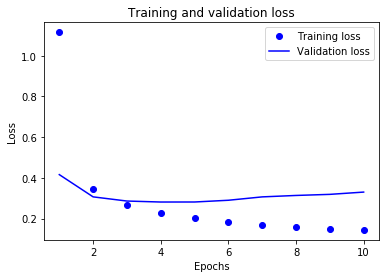

In [31]:
# plotting the training and testing loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

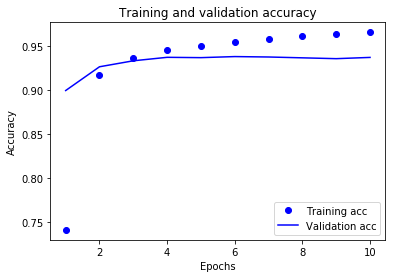

In [32]:
# plotting the training and validation accuracy
plt.clf()  # clears the figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

From both the graphs we can see that after the 3rd epoch, the network starts to overfit. So that's the optimum we should implement. We should also notice that the accuracy of the prediction is very similar to the other classification models we built earlier.

# Topic Modelling 

Topic modelling is the NLP technique of clustering similar documents. This form of unsupervised learining helps in validating a classification task as it helps us understand the similarity between diffrent classes. As we saw in my earlier classification task above, I have too many categories. By performing topic modelling on the same data I can reduce the number of classes by grouping similar classes, thereby, reducing the number of classes to predict.

Here I use Gensim library to perform this task and its starts with vectorising the texts in the corpus.

In [158]:
# create a Term Matrix with CountVectorizer
cv = CountVectorizer()
data_cv = cv.fit_transform(prod_Ncats['tokens'])
# a dataframe is created which maps each word to a number and each product document is represented as a count of each word
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
# lets add the original words and visualise how the term matrix looks like
data_dtm.index = prod_Ncats.index
data_dtm.head()

,aa,aaa,aab,aac,ab,aba,abdeckung,abelia,abhol,abs,...,전용,정품,카트리지,컬러,토너,포토,포토용지,프리미엄,프린터,플러스
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
# now transpose the Term Matrix to a Term-Document Matrix
tdm = data_dtm.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,63339,63340,63341,63342,63343,63344,63345,63346,63347,63348
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aac,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
# turn the Term-Document Matrix into a gensim format corpus by first converting the dataframe to a sparse matrix for optimal performance
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [163]:
# lets look at first two documents of the gensim corpus
print(list(corpus)[0:2])

[[(785, 1), (1967, 4), (2926, 4), (2964, 1), (3420, 1), (3423, 1), (4293, 4), (4542, 3), (4553, 2), (5512, 1)], [(5850, 1), (5851, 1)]]


In [164]:
# now I create a gensim Dictionary of the unique words with the  in the corpus
dictionary = corpora.Dictionary([line.split() for line in prod_Ncats['tokens']])

In [166]:
# Lets look at word-value mapping of the first two documents of the corpus
print([[(id2word[id], freq) for id, freq in cp] for cp in list(corpus)[:1]])

[[('business', 1), ('elitebook', 4), ('hp', 4), ('hybrids', 1), ('laptop', 1), ('laptops', 1), ('notebook', 4), ('pc', 3), ('pcs', 2), ('series', 1)]]


In [167]:
# now I build a Latent Derelict Allocation model to detect topics from the corpus.
# since this is just an experimentation, I build a 5 topic model with 5 passes or iteration to change the weights
lda_5 = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=5)
warnings.filterwarnings('ignore')
lda_5.print_topics()

[(0,
  '0.230*"tionic" + 0.103*"abs" + 0.091*"choice" + 0.063*"munkanapokon" + 0.051*"perfectkolor" + 0.050*"primadonna" + 0.042*"icona" + 0.037*"retrofits" + 0.036*"pendant" + 0.033*"bianco"'),
 (1,
  '0.030*"ushaped" + 0.020*"mediasuite" + 0.020*"planning" + 0.019*"pendant" + 0.018*"form" + 0.015*"bgn" + 0.013*"stanice" + 0.013*"mobiele" + 0.012*"category" + 0.011*"posterpapier"'),
 (2,
  '0.037*"tionic" + 0.036*"knife" + 0.035*"elettrico" + 0.033*"etui" + 0.033*"프리미엄" + 0.032*"recipes" + 0.030*"smb" + 0.030*"canon" + 0.028*"icona" + 0.027*"e복합기"'),
 (3,
  '0.119*"tionic" + 0.098*"csvc" + 0.070*"choice" + 0.069*"odezva" + 0.048*"munkanapokon" + 0.046*"icona" + 0.031*"pendant" + 0.030*"dunetop" + 0.023*"centre" + 0.022*"noodle"'),
 (4,
  '0.042*"exstream" + 0.029*"appliances" + 0.021*"colección" + 0.021*"fixe" + 0.021*"ultraplat" + 0.020*"hdcf" + 0.020*"attilio" + 0.018*"tionic" + 0.016*"lp" + 0.016*"vita"')]

# Visualisation of the Topics

To visualise this we need to run the code as somehow the plot do not show up on a Jupyter notbook like the other plots. I've added a screenshot of how the visualisation looks like in my report.

In [168]:
# Now we can visualise the topics distribution and the associated keywords.
# Each bubble on the left is a topic model and the chart on the right displays its associated keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_5, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.277055 -0.312627       1        1  28.864019
0     -0.287928 -0.028059       2        1  23.495544
3     -0.255851 -0.067081       3        1  18.684669
4      0.187154  0.268880       4        1  15.505306
2      0.079570  0.138886       5        1  13.450448, topic_info=     Category          Freq                    Term         Total  loglift  \
2926  Default  64382.000000                  tionic  64382.000000  30.0000   
4293  Default  18618.000000                     abs  18618.000000  29.0000   
1549  Default  14018.000000                    csvc  14018.000000  28.0000   
4542  Default  26493.000000                  choice  26493.000000  27.0000   
4540  Default   9886.000000                  odezva   9886.000000  26.0000   
4553  Default  18234.000000            munkanapokon  18234.000000  25.0000   
3420  Default   9172.000000            perfectkolor   9172.000000  24.0000   
7022  Default   9067.000000              primadonna   9067.000000  23.0000   
3942  Default   9757.000000                exstream   9757.000000  22.0000   
3423  Default   6601.000000               retrofits   6601.000000  21.0000   
2964  Default   5987.000000                  bianco   5987.000000  20.0000   
5512  Default  18057.000000                   icona  18057.000000  19.0000   
6512  Default   6567.000000                 ushaped   6567.000000  18.0000   
1967  Default   5044.000000                    thin   5044.000000  17.0000   
4873  Default   3633.000000               elettrico   3633.000000  16.0000   
4870  Default   3804.000000                   knife   3804.000000  15.0000   
2792  Default   4256.000000                 dunetop   4256.000000  14.0000   
4074  Default   3424.000000                    etui   3424.000000  13.0000   
3498  Default   3386.000000                    프리미엄   3386.000000  12.0000   
7024  Default   7686.000000                  noodle   7686.000000  11.0000   
4881  Default   3276.000000                 recipes   3276.000000  10.0000   
2890  Default  15209.000000                 pendant  15209.000000   9.0000   
3429  Default   3104.000000                     smb   3104.000000   8.0000   
858   Default   3099.000000                   canon   3099.000000   7.0000   
3473  Default   4522.000000              mediasuite   4522.000000   6.0000   
22    Default   4496.000000              appliances   4496.000000   5.0000   
3492  Default   2734.000000                    e복합기   2734.000000   4.0000   
785   Default   6177.000000              projectors   6177.000000   3.0000   
7128  Default   3773.000000                     zap   3773.000000   2.0000   
4613  Default   4323.000000                planning   4323.000000   1.0000   
...       ...           ...                     ...           ...      ...   
3430   Topic5   1460.238159                     sim   1461.193481   2.0055   
1966   Topic5   1452.503540                  client   1453.465576   2.0055   
2538   Topic5   1209.921631                  reflex   1210.893921   2.0054   
3501   Topic5   1153.552979                spéciale   1154.507690   2.0053   
3852   Topic5   1162.890259           professionelt   1163.875488   2.0053   
857    Topic5   1122.522461             calculators   1123.479370   2.0053   
7109   Topic5    993.869995         roboticsdefault    994.826416   2.0052   
2634   Topic5    969.784058                     bdr    970.738586   2.0052   
4352   Topic5    934.763184                     dmr    935.752441   2.0051   
4531   Topic5    700.757812                     lab    701.714355   2.0048   
5677   Topic5    702.109558                   banks    703.076294   2.0048   
307    Topic5    663.454468                     pad    664.421204   2.0047   
2165   Topic5    661.975037          highresolution    662.945190   2.0047   
120    Topic5    641.669067                  stripe    642.623596   2

# Dominant topic extraction 

In [169]:
# Now that we have buld 5 topics from the LDA model, lets try assign the most likely topics for each of the product based on their correspnding texts
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [170]:
# extract the keywords
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_5, corpus=corpus, texts=prod_Ncats['tokens'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9651,"tionic, abs, choice, munkanapokon, perfectkolo...",hp elitebook notebook pc laptops hybrids busin...
1,1,1.0,0.4001,"ushaped, mediasuite, planning, pendant, form, ...",speedlight speedlights
2,2,1.0,0.9273,"ushaped, mediasuite, planning, pendant, form, ...",electrolux cm stainless steel chimney design h...
3,3,1.0,0.9273,"ushaped, mediasuite, planning, pendant, form, ...",electrolux cm stainless steel chimney design h...
4,4,1.0,0.8400,"ushaped, mediasuite, planning, pendant, form, ...",oven electrolux nonstar oven
5,5,1.0,0.5696,"ushaped, mediasuite, planning, pendant, form, ...",canister vc motion sync home appliances vacuum...
6,6,3.0,0.4549,"tionic, csvc, choice, odezva, munkanapokon, ic...",backup plus desk für den mac mit thunderbolt t...
7,7,2.0,0.4774,"tionic, knife, elettrico, etui, 프리미엄, recipes,...",gear wrist watch strap mobile devices accessor...
8,8,2.0,0.4774,"tionic, knife, elettrico, etui, 프리미엄, recipes,...",gear wrist watch strap mobile devices accessor...
9,9,1.0,0.7996,"ushaped, mediasuite, planning, pendant, form, ...",energy rated dishwasher water consumption dish...


# Topic detection automatically

In [200]:
# To find out how many topics exist in the doc
hdp_model= models.HdpModel(corpus=corpus, id2word=dictionary)
hdp_model.show_topics()

[(0,
  '0.175*tionic + 0.113*choice + 0.079*abs + 0.046*icona + 0.040*odezva + 0.034*munkanapokon + 0.031*csvc + 0.025*globe + 0.019*venezia + 0.019*thin + 0.019*primadonna + 0.018*pendant + 0.013*hdcf + 0.013*mixed + 0.013*included + 0.013*perfectkolor + 0.012*dxa + 0.012*hdx + 0.011*retrofits + 0.011*noodle'),
 (1,
  '0.139*tionic + 0.042*knife + 0.041*interchangeablelens + 0.039*de + 0.034*sim + 0.032*masticating + 0.030*icona + 0.029*elettrico + 0.026*smb + 0.020*etui + 0.020*max + 0.018*boombar + 0.013*floating + 0.012*designed + 0.012*choice + 0.011*tesco + 0.011*soho + 0.009*wqhd + 0.009*let + 0.008*cct'),
 (2,
  '0.038*bgn + 0.029*form + 0.028*planning + 0.028*gráficos + 0.023*mediasuite + 0.018*function + 0.016*ethernetmodul + 0.014*powder + 0.014*быстросохнущая + 0.011*surroundcook + 0.010*brilhante + 0.009*pendant + 0.009*packed + 0.009*puts + 0.008*avengers + 0.008*denim + 0.008*autoloader + 0.007*cool + 0.007*tionic + 0.007*controllers'),
 (3,
  '0.047*ushaped + 0.031*tion